# What is a Recurrent Neural Network?

A recurrent layer is just a memory cell that computes. In diagrams, you may see it represented as having many cells, but it is just one cell used to calculate an output over a set amount of time steps. The cell calculates Y_0 at X_0 then moves on to calculating Y_1 at X_1 and so on. However, from X_0 to X_1 the memory cell produces a state vector. This state factor is used in the next time step as an additional input factor. This state factor is why it is called a recurrent neural network. Just as x +=1 is a recurrent function to add 1 every time to X, every time step receives an state vector from the last time step.

This architecture enables you to use any sequence length as long as the parameters remain constant. An RNN can be though of as word context of reading a sentence. As you read the a sentence you may only be focusing on one word, however, if you encounter a word that is a homphone such as lead you will understand the context. You can immediate notice if lead is the verb for "guiding" or the soft metal which is a noun.

## Setup

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [33]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    import tensorflow as tf # Import tensorflow within the function
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
file_path = '/content/drive/MyDrive/DATA CAPSTONE/stock_data.csv'

stock_df = pd.read_csv(file_path, skiprows=2, header=None)

# Assign column names to the 'spy' DataFrame
stock_df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce')
stock_df = stock_df.dropna(subset=['Date'])  # Remove rows with invalid dates
stock_df = stock_df.set_index('Date')

# Print some info
print(stock_df.head())
print(stock_df.tail())
print("\nDataFrame columns:")
print(stock_df.columns)

                  Close         High          Low         Open        Volume
Date                                                                        
2000-01-03  1455.219971  1478.000000  1438.359985  1469.250000  9.318000e+08
2000-01-04  1399.420044  1455.219971  1397.430054  1455.219971  1.009000e+09
2000-01-05  1402.109985  1413.270020  1377.680054  1399.420044  1.085500e+09
2000-01-06  1403.449951  1411.900024  1392.099976  1402.109985  1.092300e+09
2000-01-07  1441.469971  1441.469971  1400.729980  1403.449951  1.225200e+09
                  Close         High          Low         Open        Volume
Date                                                                        
2024-12-24  6040.040039  6040.100098  5981.439941  5984.629883  1.757720e+09
2024-12-26  6037.589844  6049.750000  6007.370117  6024.970215  2.904530e+09
2024-12-27  5970.839844  6006.169922  5932.950195  6006.169922  3.159610e+09
2024-12-30  5906.939941  5940.790039  5869.160156  5920.669922  3.433250e+09

<ipython-input-8-57acdad6be9f>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce')


In [9]:

# Save target series
series = stock_df['Close']



total_data_points = len(stock_df)
train_split_index = int(total_data_points * 0.65)  # 60% for training
valid_split_index = int(total_data_points * 0.8)  # 80% for training + validation
test_split_index = int(total_data_points * 1)  # 100% for testing

x_train = stock_df[:train_split_index]
x_valid = stock_df[train_split_index:valid_split_index]
x_test = stock_df[valid_split_index:]

print(f"Train data shape: {x_train.shape}")
print(f"Validation data shape: {x_valid.shape}")
print(f"Test data shape: {x_test.shape}")


Train data shape: (4087, 5)
Validation data shape: (944, 5)
Test data shape: (1258, 5)


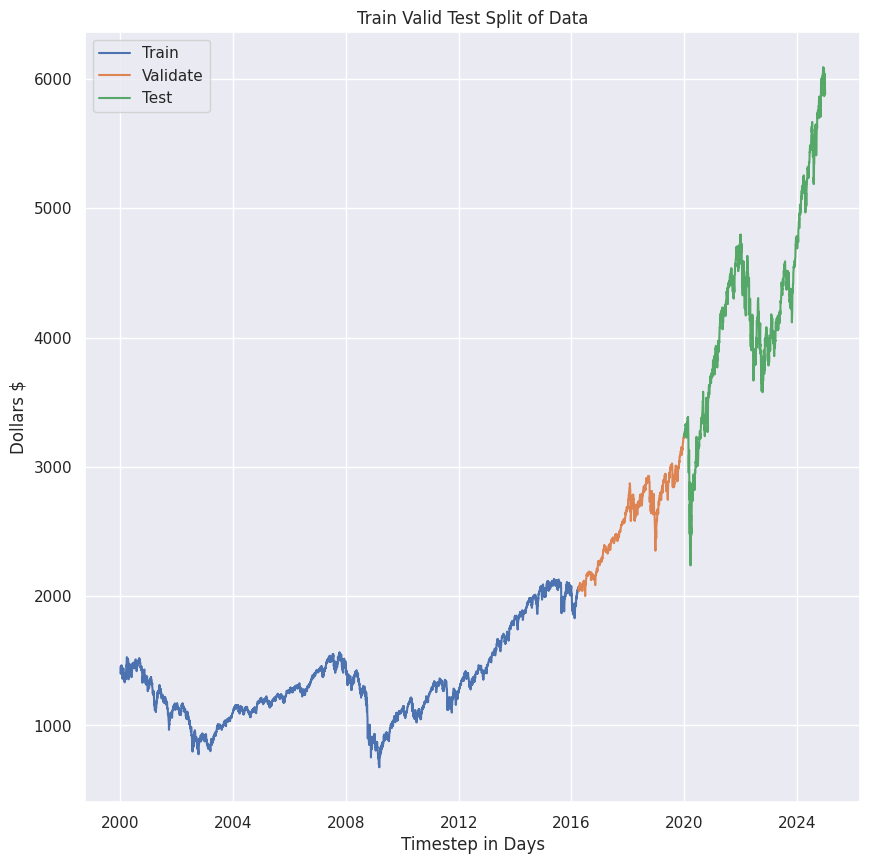

In [10]:

# Set style for charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Plotting the data
plt.plot(x_train['Close'], label='Train')
plt.plot(x_valid['Close'], label='Validate')
plt.plot(x_test['Close'], label='Test')

# Adding labels and title
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()

# Display the plot
plt.show()

In [11]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [16]:
display(x_train_values.shape)
display(normalized_x_train.shape)
display(normalized_x_valid.shape)
display(normalized_x_test.shape)

(20435, 1)

(20435, 1)

(4720, 1)

(6290, 1)

## Simple RNN Forecasting

The input for the memory cell at each time step is the batch size by our feature dimensionality (1). The output is thiese same two dimensions times the number of units in the memory cell. Our memory cell is comprised of 100 units in both layers. So the output of our RNN layer is batch(128), window_size(30), and number of units (100) which is obviously 3 dimensional. The output Y_0 is the state vector which is used when calculating Y_1 at the next time step.

In this instance we are doing sequence to vector which means we ignore all outputs except for the one at the very last time step. This is the default behavior of all reccurent layers in Keras unless return_sequences = True is selected. This sequence to vector takes in a batch (128) of time windows and outputs the next time step of window of values. This one at a time output proves to be very slow when training.

For a faster training convergence, we use a sequence to sequence RNN. Compared to the sequence to vector which adjusted the gradient of the loss from the very end of the model all the at layer 2 unit 100, the sequence to sequence RNN calculates the loss at each time step and backpropagates the loss from there. This provides much more gradients and speeds up training. It is important to note we still ignore all outputs besides the last one. We just calculate all intermediate values to update the gradient more quickly.

In [19]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

# Clear any backend stored data (useful for multiple iterations)
keras.backend.clear_session()

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check if GPU is available and use it
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used for training.")
    device = '/GPU:0'  # Specify the device (GPU) to use
else:
    print("GPU not available, using CPU.")
    device = '/CPU:0'

# Set window size
window_size = 30

# Create 2D batches of batch size and features (1 feature = 1 time step in window)
train_set = window_dataset(normalized_x_train, window_size, batch_size=128)

# Define the model
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Add a 3rd dimension (feature dimensionality which in this case is univariate)
                        input_shape=[None]),  # Input shape is flexible to allow windows of any size
    keras.layers.SimpleRNN(100, return_sequences=True),  # Takes in sequences (batch_size, time, feature)
    keras.layers.SimpleRNN(100),  # Produces a single vector after processing the sequences
    keras.layers.Dense(1),  # Output layer that produces 1 output
])

# Learning rate scheduler to gradually increase the learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

# Define the optimizer
optimizer = keras.optimizers.Nadam(learning_rate=1e-7)

# Compile the model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Fit the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

# Ensure GPU is activated (optional verification)
print("Device being used for training:", device)


GPU is available and will be used for training.
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0012 - mae: 0.0350 - learning_rate: 1.0000e-05
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 4.9729e-04 - mae: 0.0218 - learning_rate: 1.1220e-05
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.1799e-04 - mae: 0.0170 - learning_rate: 1.2589e-05
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.3409e-04 - mae: 0.0135 - learning_rate: 1.4125e-05
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.9629e-04 - mae: 0.0116 - learning_rate: 1.5849e-05
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7433e-04 - mae: 0.0103 - learning_rate: 1.7783e-05
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.5763e-04 - mae: 0.0091 - learning_rate: 1.9953e-05
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.4906e-04 - mae: 0.0084 - learning_rate: 2.2387e-05
Epoch 9/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.4138e-04 - mae: 0.0079 - learning_rate: 2.5119e-05
Epoch 10/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 1.4038e-04 - mae: 0.0079 - le

(np.float64(1e-05), np.float64(1.0), np.float64(0.0), np.float64(0.1))

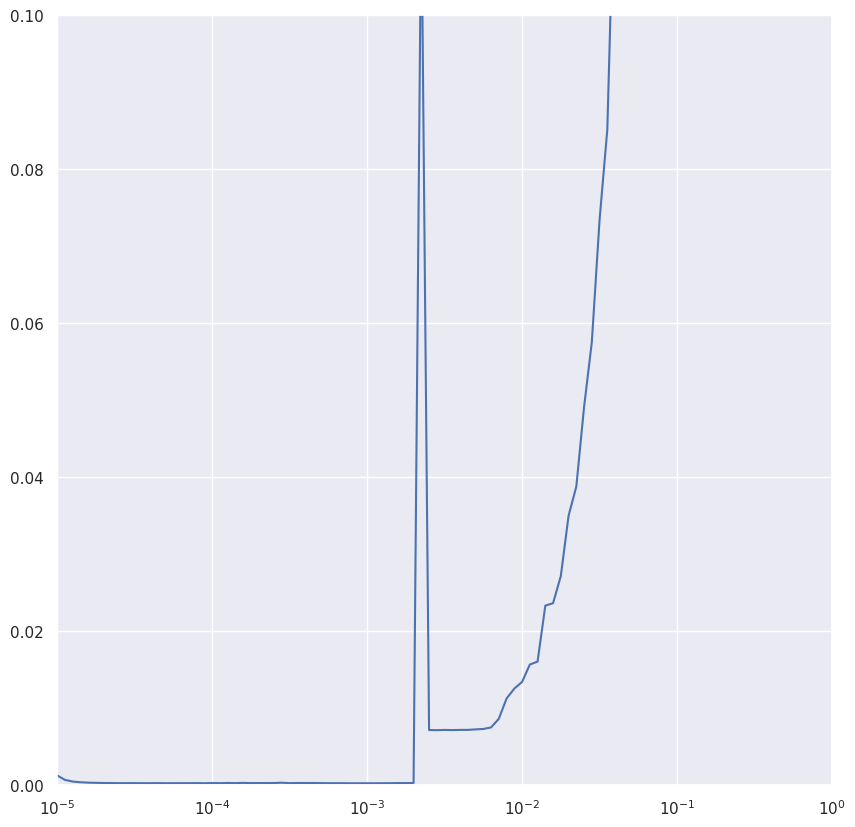

In [22]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-5, 1, 0, .1])

In [36]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(normalized_x_train, window_size, batch_size=128)
valid_set = window_dataset(normalized_x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
])
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Set early stopping to prevent over fitting
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# save best model to load later
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.keras", save_best_only=True)

# compile model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    160/Unknown 9s 30ms/step - loss: 0.0015 - mae: 0.0349

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0015 - mae: 0.0349 - val_loss: 3.3396e-04 - val_mae: 0.0141
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 1.9721e-04 - mae: 0.0104 - val_loss: 2.6128e-04 - val_mae: 0.0110
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 1.4297e-04 - mae: 0.0079 - val_loss: 2.8846e-04 - val_mae: 0.0119
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 1.4055e-04 - mae: 0.0077 - val_loss: 2.5040e-04 - val_mae: 0.0099
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1.3029e-04 - mae: 0.0067 - val_loss: 2.5609e-04 - val_mae: 0.0105
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.3412e-04 - mae: 0.0070 - val_loss: 2.6345e-04 - val_mae: 0.0122
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 1.3420e-04 - mae: 0.0068 - val_loss: 2.4257e-04 - val_mae: 0.0086
Epoch 8/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 1.3054e-04 - mae: 0.0065 - val_loss: 2.4234e-04 - val_

In [30]:
model = keras.models.load_model("/content/my_checkpoint.keras",safe_mode=False)

In [37]:
rnn_forecast = model_forecast(
    model,
    spy_normalized_to_traindata[len(spy_normalized_to_traindata) - len(x_test) - window_size:-1], # Use integer-based indexing for the NumPy array
    window_size)[:, 0]

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [38]:
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(1258,)

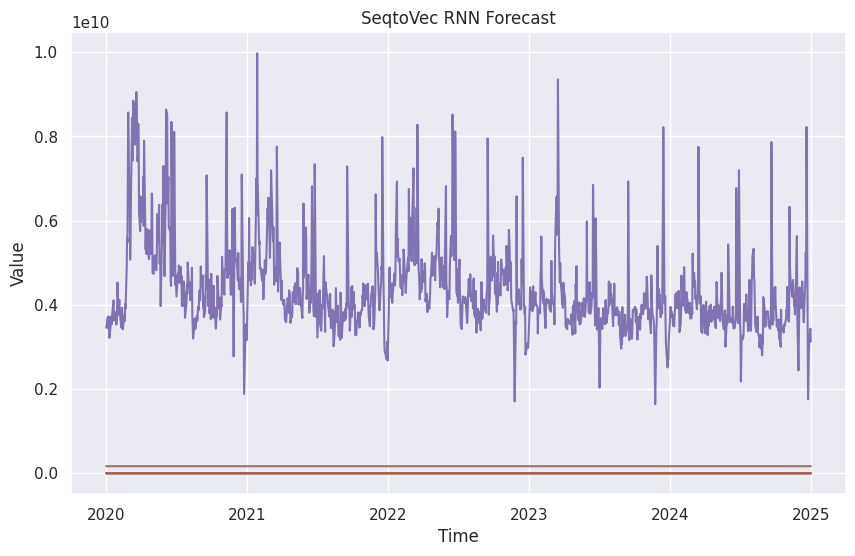

In [39]:
plt.figure(figsize=(10,6))

plt.title('SeqtoVec RNN Forecast')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plot_series(x_test.index, x_test)
plot_series(x_test.index, rnn_unscaled_forecast)

In [49]:
from sklearn.metrics import mean_absolute_error
rnn_mse_score = mean_absolute_error(x_test['Close'], rnn_forecast)
display(rnn_mse_score)

4259.592340638855

## Sequence-to-Sequence Forecasting

In [47]:
def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

The cell below illustrates exactly what the function above is doing. the cell above creates batches and laebls for those batches. The point Y[0] is the label for X[0] to try to calculate.

In [50]:
# Show example of what seq-seq looks like
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3, batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [52]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

# in the seq2seq_window we removed the need for the lambda layer to expand dimensions as it is already 3D
train_set = seq2seq_window_dataset(normalized_x_train.flatten(), window_size,
                                   batch_size=128)

# Create model
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1), # now dense layer is applied at every time step
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 30))

# choose optimizer
optimizer = keras.optimizers.Nadam(learning_rate=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# create history callback from fit
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0025 - mae: 0.0516 - learning_rate: 1.0000e-05
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 8.3629e-04 - mae: 0.0213 - learning_rate: 1.0798e-05
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 7.4112e-04 - mae: 0.0186 - learning_rate: 1.1659e-05
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.0381e-04 - mae: 0.0177 - learning_rate: 1.2589e-05
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.8094e-04 - mae: 0.0172 - learning_rate: 1.3594e-05
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.7028e-04 - mae: 0.0173 - learning_rate: 1.4678e-05
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.6623e-04 - mae: 0.0174 - learning_rate: 1.5849e-05
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 6.6948e-04 - mae: 0.0178 - learning_rate: 1.7113e-05
Epoch 9/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.7440e-04 - mae: 0.0182 - learning_rate: 1.8478e-05
Epoch 10/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.8296e-04 - mae: 0.0186 - le

(np.float64(1e-05), np.float64(1.0), np.float64(0.0), np.float64(0.1))

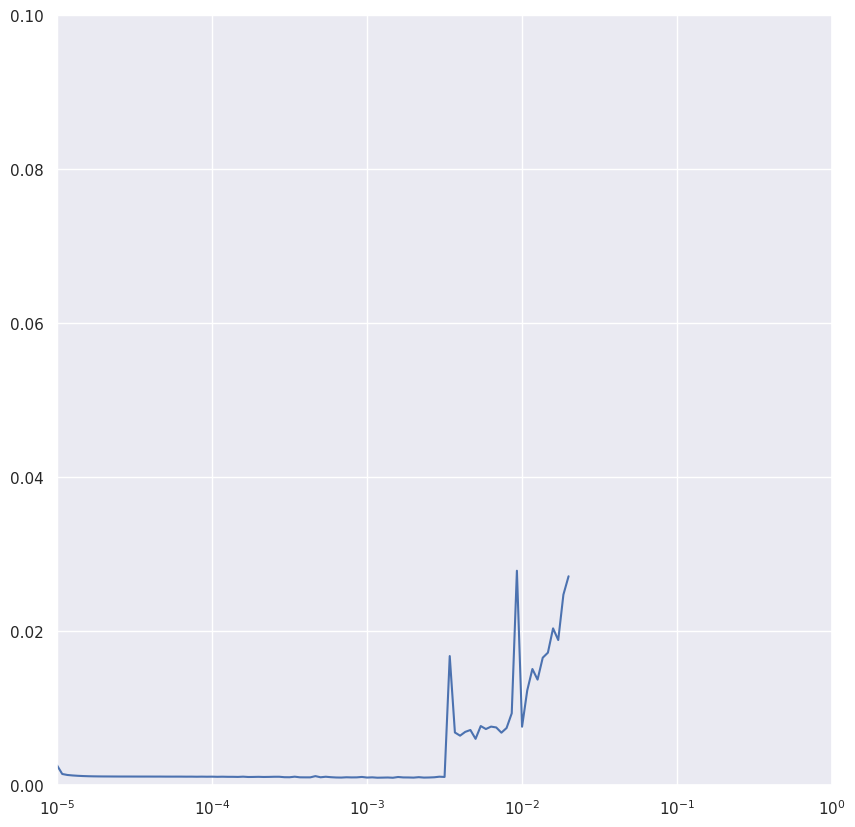

In [54]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-5, 1, 0, .1])

In [55]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequences
window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train.flatten(), window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid.flatten(), window_size,
                                   batch_size=128)

# Create model for seq:seq RNN
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
])

# choose optimizer and LR
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)

# set model params
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=20)

# set model checkpoint to save best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_noseqtoseq.keras", save_best_only=True)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0012 - mae: 0.0250 - val_loss: 0.0015 - val_mae: 0.0306
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 8.7280e-04 - mae: 0.0215 - val_loss: 0.0015 - val_mae: 0.0304
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 8.7491e-04 - mae: 0.0217 - val_loss: 0.0015 - val_mae: 0.0303
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 8.7659e-04 - mae: 0.0217 - val_loss: 0.0015 - val_mae: 0.0304
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 9.0082e-04 - mae: 0.0219 - val_loss: 0.0015 - val_mae: 0.0307
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 8.9453e-04 - mae: 0.0221 - val_loss: 0.0015 - val_mae: 0.0309
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 8.8152e-04 - mae: 0.0217 - val_loss: 0.0015 - val_mae: 0.0298
Epoch 8/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 8.5812e-04 - mae: 0.0210 - val_loss: 0.0015 - val_mae: 0.0290
Epoch 9/50

In [ ]:
# recall best model
model = keras.models.load_model("my_checkpoint_noseqtoseq.keras")

In [58]:
# create forecast and clip to only show test values
rnn_forecast = model_forecast(model, spy_normalized_to_traindata.flatten()[..., np.newaxis], window_size)

# Instead of subtracting window_size from the minimum, slice using integers:
rnn_forecast = rnn_forecast[window_size : len(x_test) + window_size, -1, 0]
# The slicing starts from 'window_size' to ensure alignment with the test set.

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [59]:
# Get data back to normal scale
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(1258,)

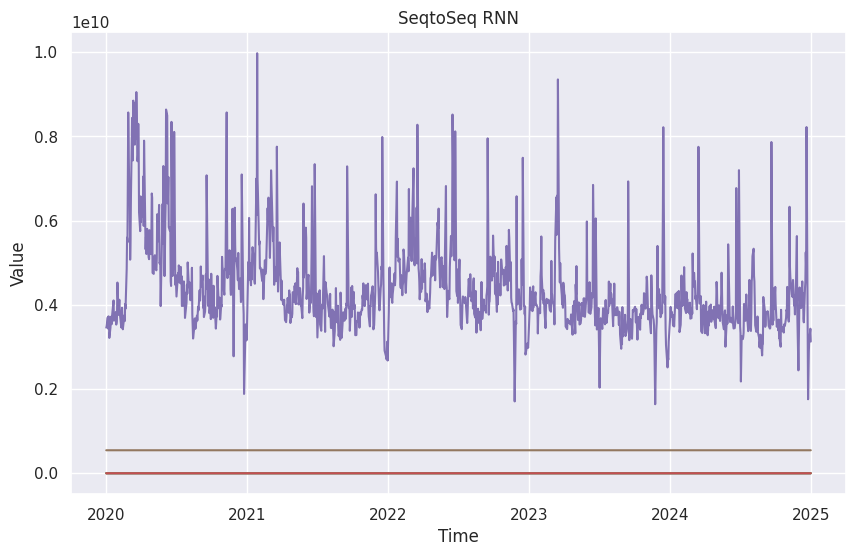

In [60]:
# Plot results
plt.figure(figsize=(10, 6))
plt.title('SeqtoSeq RNN')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plot_series(x_test.index, x_test)
plot_series(x_test.index, rnn_unscaled_forecast)

In [62]:
from sklearn.metrics import mean_absolute_error
rnn_mse_score = mean_absolute_error(x_test['Close'], rnn_forecast)
display(rnn_mse_score)

4259.559265931106